In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from utils import *

## Load data

In [2]:
base_folder = 'data'
dataset = 'indoor'
folder = os.path.join(base_folder, dataset)

In [3]:
info = load_info(folder)
user_info = load_user_info(folder, info)
gaze = load_gaze(folder, info)
odometry = load_odometry(folder, info)
_, r_realsense_pupil = load_extrinsics(folder)

Fix sign flip issue in gaze point

In [4]:
gaze['gaze_point'] = gaze.gaze_point.pipe(correct_sign)

## Analysis

### Reference frame transformations

In [5]:
r_pupil_eyes = shortest_arc_rotation(
    gaze.gaze_point, np.array([0., 0., 1.])[None, :])

In [6]:
r_world_head = stack_rotations(
    odometry.orientation.values,
    r_realsense_pupil,
    r_pupil_anatomic)

r_world_eyes = stack_rotations(
    odometry.orientation,
    r_realsense_pupil,
    r_pupil_eyes.interp(time=odometry.time),
    r_pupil_anatomic)

In [7]:
linear_velocity_head = odometry.linear_velocity \
    .pipe(rotate_vectors, r_world_head, inverse=True)

angular_velocity_head = odometry.angular_velocity \
    .pipe(rotate_vectors, r_world_head, inverse=True)

linear_velocity_head_spherical = linear_velocity_head \
    .pipe(cartesian_to_spherical) \
    .pipe(center_spherical_coordinates) \
    .pipe(radians_to_degrees)

linear_velocity_eyes_spherical = odometry.linear_velocity \
    .pipe(rotate_vectors, r_world_eyes, inverse=True) \
    .pipe(cartesian_to_spherical) \
    .pipe(center_spherical_coordinates) \
    .pipe(radians_to_degrees)

gaze_point_spherical = gaze.gaze_point \
    .pipe(rotate_vectors, r_pupil_anatomic, inverse=True) \
    .pipe(cartesian_to_spherical) \
    .pipe(center_spherical_coordinates) \
    .pipe(radians_to_degrees)

### Data exclusion

#### Gaze data

In [8]:
min_gaze_confidence = 0.8
min_tracker_confidence = 2
window_len = 100
max_eye_velocity_vor = 200
max_eye_velocity_walk = 60

Smooth gaze point and norm pos with boxcar filter

In [9]:
gaze_point_smoothed = gaze_point_spherical \
    .pipe(smooth, window_len=window_len)

Compute gaze velocity

In [10]:
gaze_vel_smoothed = gaze_point_smoothed \
    .differentiate('time', datetime_unit='s') \
    .rename('gaze_velocity')

gaze_vel_norm = gaze_vel_smoothed \
    .sel(spherical_axis=['theta', 'phi']) \
    .reduce(np.linalg.norm, dim='spherical_axis')

Clean gaze point and velocity

In [11]:
gaze_point_clean = gaze_point_smoothed \
    .pipe(clean,
          gaze.gaze_confidence > min_gaze_confidence,
          gaze_vel_norm < max_eye_velocity_walk)

gaze_vel_clean = gaze_vel_smoothed \
    .pipe(clean,
          gaze.gaze_confidence > min_gaze_confidence,
          gaze_vel_norm < max_eye_velocity_vor)

#### Head tracking data

In [12]:
linear_velocity_head = linear_velocity_head \
    .pipe(clean, odometry.tracker_confidence >= min_tracker_confidence)

angular_velocity_head = angular_velocity_head \
    .pipe(clean, odometry.tracker_confidence >= min_tracker_confidence)

linear_velocity_head_spherical = linear_velocity_head_spherical \
    .pipe(clean, odometry.tracker_confidence >= min_tracker_confidence)

linear_velocity_eyes_spherical = linear_velocity_eyes_spherical \
    .pipe(clean, odometry.tracker_confidence >= min_tracker_confidence)

### Vestibulo-ocular reflex

In [15]:
d1 = float(user_info['tvor_close_distance'])
d2 = float(user_info['tvor_far_distance'])

conditions = {
    'avor_yaw': ('z', 'phi', -angular_velocity_head/np.pi*180),
    'avor_pitch': ('y', 'theta', -angular_velocity_head/np.pi*180),
    'tvor_close': ('z', 'theta', np.arctan(linear_velocity_head/d1)/np.pi*180),
    'tvor_far':  ('z', 'theta', np.arctan(linear_velocity_head/d2)/np.pi*180),
}

titles = {
    'avor_yaw': r'$\bf{{{A}}}$ Eye yaw vs. negative head yaw velocity',
    'avor_pitch': r'$\bf{{{B}}}$ Eye pitch vs. negative head pitch velocity',
    'tvor_close': r'$\bf{{{C}}}$ Eye pitch vs. vertical head velocity (%.3f m distance)' % d1,
    'tvor_far': r'$\bf{{{D}}}$ Eye pitch vs. vertical head velocity (%.3f m distance)' % d2,
}

v_eyes = {
    condition: gaze_vel_clean.sel(
        time=slice(user_info[f'{condition}_start'], 
                   user_info[f'{condition}_end']),
        spherical_axis=s_axis)
    for condition, (_, s_axis, _) in conditions.items()
}

v_head = {
    condition: head_vel.sel(
        time=slice(user_info[f'{condition}_start'], 
                   user_info[f'{condition}_end']),
        cartesian_axis=c_axis)
    for condition, (c_axis, _, head_vel) in conditions.items()
}

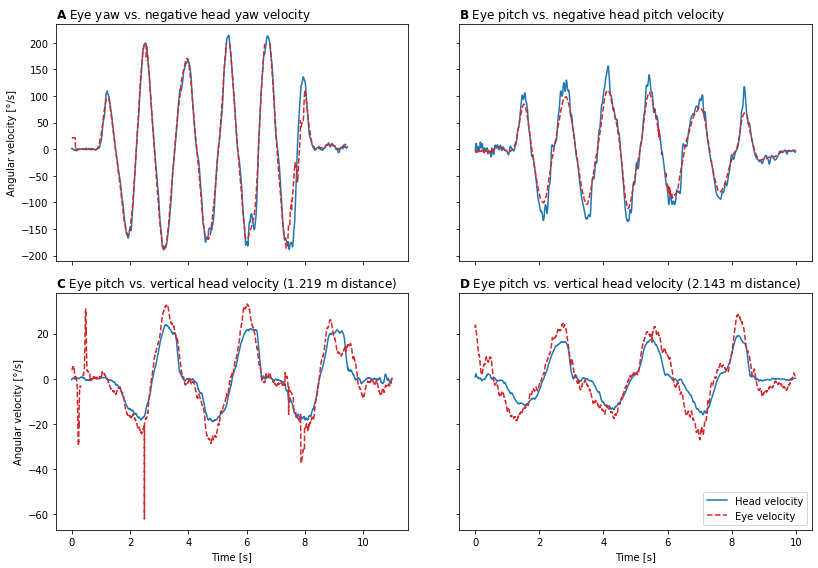

In [16]:
fig, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12, 8))
axarr = axarr.flatten()

for idx, (condition, title) in enumerate(titles.items()):
    
    axarr[idx].plot(
        (v_head[condition].time - v_head[condition].time[0]).astype(float)/1e9, 
        v_head[condition], color='tab:blue', label='Head velocity')
    
    axarr[idx].plot(
        (v_eyes[condition].time - v_eyes[condition].time[0]).astype(float)/1e9, 
        v_eyes[condition], color='tab:red', linestyle='dashed', label='Eye velocity')
    
    axarr[idx].set_title(title, loc='left')
    
    if idx >= 2:
        axarr[idx].set_xlabel('Time [s]')
    if idx % 2 == 0:
        axarr[idx].set_ylabel('Angular velocity [°/s]')
    if idx == 3:
        axarr[idx].legend(loc='lower right')
        
fig.tight_layout()

In [17]:
fig.savefig(f'results/vor_{dataset}.png', dpi=300, bbox_inches='tight')

### Heatmaps

In [18]:
max_angle = 45
nbins = 100

In [19]:
def compute_2d_histogram(
        data, dim, ix, iy, nbins=nbins, 
        xrange=(-max_angle, max_angle), yrange=(-max_angle, max_angle)):
    """ Compute 2D histogram from DataArray. """
    return histogram2d(
        data.sel(**{dim: ix}), data.sel(**{dim: iy}), 
        range=[xrange, yrange], bins=nbins).T

h_v_lin = compute_2d_histogram(
    linear_velocity_head_spherical, 'spherical_axis', 'phi', 'theta')

h_v_lin_eyes = compute_2d_histogram(
    linear_velocity_eyes_spherical, 'spherical_axis', 'phi', 'theta')

h_p_gaze = compute_2d_histogram(
    gaze_point_spherical, 'spherical_axis', 'phi', 'theta')

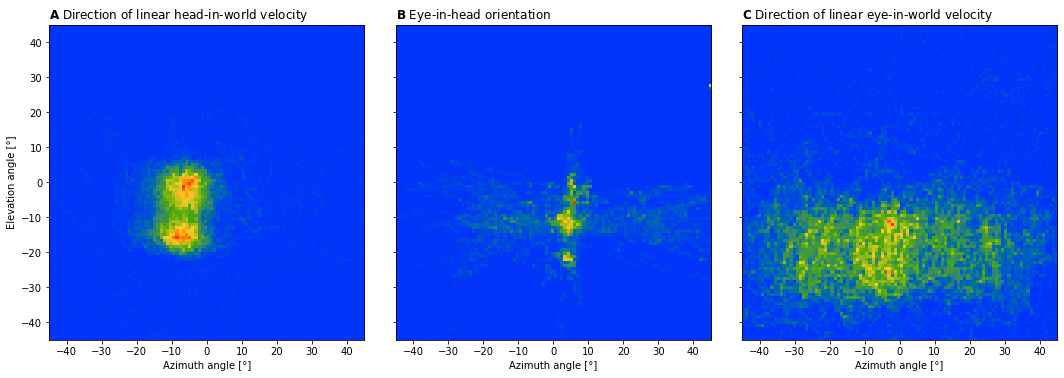

In [20]:
import colorcet as cc

fig, axarr = plt.subplots(
    ncols=3, figsize=(15, 5), sharey=True)

axarr[0].imshow(h_v_lin, cmap=cc.cm.rainbow, 
                extent=[-max_angle, max_angle, -max_angle, max_angle])
axarr[0].set_ylabel('Elevation angle [°]')
axarr[0].set_xlabel('Azimuth angle [°]')
axarr[0].set_title(
    r'$\bf{{{A}}}$ Direction of linear head-in-world velocity', loc='left')

axarr[1].imshow(h_p_gaze, cmap=cc.cm.rainbow, 
                extent=[-max_angle, max_angle, -max_angle, max_angle])
axarr[1].set_xlabel('Azimuth angle [°]')
axarr[1].set_title(
    r'$\bf{{{B}}}$ Eye-in-head orientation', loc='left')

axarr[2].imshow(h_v_lin_eyes, cmap=cc.cm.rainbow, 
                extent=[-max_angle, max_angle, -max_angle, max_angle])
axarr[2].set_xlabel('Azimuth angle [°]')
axarr[2].set_title(
    r'$\bf{{{C}}}$ Direction of linear eye-in-world velocity', loc='left')

fig.tight_layout()

In [21]:
fig.savefig(f'results/heatmaps_{dataset}.png', dpi=300, bbox_inches='tight');

Fin